In [29]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.sparse import coo_matrix 


from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.stores import stores_dir

from tyssue.draw import sheet_view
from tyssue.generation import spherical_monolayer

from tyssue.dynamics import model_factory, effectors
from tyssue.solvers import QSSolver
from tyssue import ClosedMonolayerGeometry as geom

organo = spherical_monolayer(10, 11, Nc=120, apical="in")

model = model_factory(
    [
        effectors.LineTension,
        effectors.LumenVolumeElasticity,
        effectors.CellAreaElasticity,
        effectors.CellVolumeElasticity,
        effectors.SurfaceTension,
    ]
)
geom.update_all(organo)

## Initial model settings
dyn_specs = {
    "settings": {
        "lumen_prefered_vol": organo.settings["lumen_vol"],
        "lumen_vol_elasticity": 1e-1 / organo.Nc,
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": organo.cell_df.vol.mean(),
        "vol_elasticity": 1.0,
        "area_elasticity": 1.0,
        "prefered_area": organo.cell_df.area.mean(),
    },
    "face": {"surface_tension": 1.0},
    "edge": {"line_tension": 1e-5},
}


solver = QSSolver()
organo.update_specs(dyn_specs, reset=True)

res = solver.find_energy_min(organo, geom, model)
print(res["success"])


True


In [5]:
fig, mesh = sheet_view(organo, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), projectionMatrix=(2.3558523658237527, 0.0,…

### Équations du modèle

$$
E = \sum_c \frac{K_v}{2}(V_c - V_c^0)^2 + \frac{K_{A, c}}{2}(A_c - A_c^0)^2 +  \sum_\alpha T_\alpha A_\alpha + \sum_{ij}\Lambda_{ij}
$$
We set $K_c = 1$ to fix the unit energy.

The force on each vertex is the opposite of the energy gradient w/r to the vertex position.

$$
\nabla_i E = \left(\frac{\partial E}{\partial x_i}, \frac{\partial E}{\partial y_i}, \frac{\partial E}{\partial z_i}\right) = \frac{\partial E}{\partial \mathbf{r}_i}
$$

The idea is to write a linear system of equations with the dynamical parameters 
as unknowns, and one equation per vertex coordinate.

Thus, there are $3N_c + N_f + N_e$ uknowns (defined as the vector $P$) and $3N_v$ equations.

$$
\begin{eqnarray}
P = (\delta V_c, K_{A, c}, \delta A_c), \quad c &\in& (0, \cdots N_c)\\
 T_\alpha, \quad \alpha &\in& (0, \cdots N_f)\\
 \Lambda_{ij}, \quad {ij} &\in& (0, \cdots N_e) \\
\end{eqnarray}
$$

It's easier to treat directly with $\delta V_c = (V_c - V_c^0)$ and similarly $\delta A_c$

Let's go term by term:

#### Volume and area elasticities

$$
\nabla_i \sum_c \frac{1}{2}(V_c - V_c^0)^2 = \nabla_i \sum_c \delta V_c \nabla_i \delta V_c 
$$


In tyssue, an edge belongs to a single face of each cell. The volume gradient above $\nabla_i \delta V_c$ can be rewritten over all the edge incident on and going from vertex i. Each of those edges define a tetrahedron. The volume gradient of edge $ij$ for cell $c$ is the same as the volume gradient of the tetrahedron defined by the edge $ij$ and its associated face and cell centers. The above equation can be rewritten as two sums, over the  edges incomming and outgoing from the vertex i.  

$$
\nabla_i \sum_c \frac{1}{2}(V_c - V_c^0)^2 = 
        \sum_{ij} \delta V_{c, ij \in c} \nabla_{ij} V_{c, ij \in c}
        - \sum_{ji} \delta V_{c, ji \in c} \nabla_{ji} V_{c, ji \in c} 
$$

This is why the [`volume grad`](https://github.com/DamCB/tyssue/blob/master/tyssue/dynamics/bulk_gradients.py#L8) function returns two vertices over the source (outgoing) and target (incomming) edges.


Similarly:

$$
\nabla_i \sum_c \frac{K_{A, c}}{2}(V_c - V_c^0)^2 = 
            \sum_{ij} K_{A, c, ij \in c} \delta A_{c, ij \in c} \nabla_{ij} A_{c, ij \in c}
            - \sum_{ji} K_{A, d, ij \in d} \delta A_{d, ji \in c} \nabla_{ji} A_{d, ji \in d}
$$


#### Surface tension
With the same reasoning

$$
\nabla_i T_\alpha A_\alpha =  
        \sum_{ij} T_{\alpha, ij \in \alpha} \nabla_{ij} A_{\alpha, ij \in \alpha}
        - \sum_{ji} T_{\beta, ji \in \beta} \nabla_{ji} A_{\beta, ji \in \beta} 
$$

#### Line tension

Once again:

$$
\nabla_i \Lambda_{ij} \ell_{ij} =  
        \sum_{ij} \Lambda_{ij} \nabla_i \ell_{ij}
        - \sum_{ji} \Lambda_{ji} \nabla_i \ell_{ji}  
        = \sum_{ij} \Lambda_{ij} \mathbf{u}_{ij}
        - \sum_{ji} \Lambda_{ji} \mathbf{u}_{ji}  
$$

With $\mathbf{u}_{ij} = \mathbf{r}_{ij} / \ell_{ij}$

### Implementation

As often in tyssue, the good strategy is to compute everything in the edge space, and sum only in the end. The system of equations must be written in matrix form:

$$
M\cdot P = 0^{3N_v}
$$

With $M$ a $(3N_c+N_f+N_e) \times 3N_v$ matrix and $P$ the parameter vector. Each line of the matrix corresponds to the equation for a vertex coordinates. We write the $x_i$ at lines $3i$ the $y_i$ at lines $3i + 1$ and the $z_i$ at lines $3i + 2$.  

In order to build the matrix M, we have to know in which equations each term $p_k$ of the vector $P$ appears. We can build one matrice for each term in the gradient and concatenate them in the end. For this we use connectivity matrices.

For example in the case of the line tension,  the term $\Lambda{ij}$ appears at lines $3i, 3i+1, 3i + 2$ and $3j, 3j+1, 3j + 2$. Assuming $\Lambda_{ij}$ is the $k$th term in $P$ we have. 

$$
\begin{eqnarray}
m_{k, 3i} &=& x_i / \ell_{ij}\\
m_{k, 3i+1} &=& y_i / \ell_{ij}\\
m_{k, 3i+2} &=& z_i / \ell_{ij}\\
m_{k, 3j} &=& -x_j / \ell_{ij}\\
m_{k, 3j+1} &=& -y_j / \ell_{ij}\\
m_{k, 3j+2} &=& -z_j / \ell_{ij}\\
\end{eqnarray}
$$


We thus have $6N_e$ non null terms in the tension matrix



Is the shape correct?
True


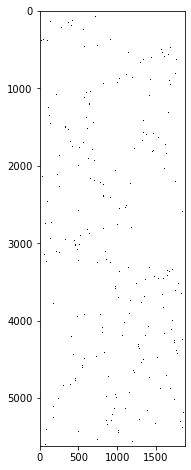

In [109]:
# We use a sparse matrix definition to build the matrix

lengths = organo.edge_df['length'].to_numpy() # ℓ_i

srce_terms = (organo.edge_df[["sx", "sy", "sz"]].to_numpy()
              / lengths[:, None]).ravel()
trgt_terms = -(organo.edge_df[["tx", "ty", "tz"]].to_numpy()
               / lengths[:, None]).ravel()

data = np.concatenate((srce_terms, trgt_terms))

rows = organo.edge_df.index.to_numpy().repeat(6)

cols = np.concatenate((
    3*organo.edge_df['srce'].to_numpy().repeat(3),
    3*organo.edge_df['trgt'].to_numpy().repeat(3)))

cols += np.tile([0, 1, 2], 2*organo.Ne)

line_tension_mat = coo_matrix((data, (rows, cols)))

print("Is the shape correct?")
print(line_tension_mat.shape == (organo.Ne, 3 * organo.Nv))

fig, ax = plt.subplots()
ax.imshow((line_tension_mat != 0).todense(), cmap='Greys', interpolation=None)
fig.set_size_inches(8, 8)


To do the same for the surface tension and elasticities, we need to know which vertex belongs to which cell or face.

For example let's work on the surface tension:


$$
\nabla_i \sum_\alpha(T_\alpha A_\alpha) =  
        \sum_\alpha T_\alpha (\nabla_{ij} A_{\alpha} - \nabla_{ki} A_{\alpha ki}) 
$$
Assuming $j$ and $k$ are the two vertices of face $\alpha$ connected to vertex $i$

Let's assume that the apical vertex $i$ belongs to 3 cells and thus 9 faces (3 per cell). There will be non zero terms in those 9 lines and the 3 rows of vertex i. For each line (thus each face), there is a term corresponding to the triangle for which vertex i is a source and a term for which vertex i is a target.

If surface tension  $T_\alpha$ is at line $n$ of P, we have:

$$
\begin{eqnarray}
m_{n, 3i} &=& T_\alpha (\partial A_\alpha / \partial {x_{ij}} - \partial A_\alpha / \partial {x_{ki}})\\
m_{n, 3i+1} &=& T_\alpha (\partial A_\alpha / \partial {y_{ij}} - \partial A_\alpha / \partial {y_{ki}})\\
m_{n, 3i+2} &=& T_\alpha (\partial A_\alpha / \partial {z_{ij}} - \partial A_\alpha / \partial {z_{ki}})\\
\end{eqnarray}
$$


If we flip this now, for each edge there are 3 terms for the source vertex and 3 terms for the target vertex.


$$
\begin{eqnarray}
m_{n, 3i} &=& T_\alpha (\partial A_\alpha / \partial {x_{ij}} - \partial A_\alpha / \partial {x_{ki}})\\
m_{n, 3i+1} &=& T_\alpha (\partial A_\alpha / \partial {y_{ij}} - \partial A_\alpha / \partial {y_{ki}})\\
m_{n, 3i+2} &=& T_\alpha (\partial A_\alpha / \partial {z_{ij}} - \partial A_\alpha / \partial {z_{ki}})\\
m_{n, 3j} &=& T_\alpha (\partial A_\alpha / \partial {x_{jl}} - \partial A_\alpha / \partial {x_{ij}})\\
m_{n, 3j+1} &=& T_\alpha (\partial A_\alpha / \partial {y_{jl}} - \partial A_\alpha / \partial {y_{ij}})\\
m_{n, 3j+2} &=& T_\alpha (\partial A_\alpha / \partial {z_{jl}} - \partial A_\alpha / \partial {z_{ij}})\\
\end{eqnarray}
$$


In [106]:
from tyssue.dynamics.sheet_gradients import area_grad
from tyssue.dynamics.bulk_gradients import volume_grad


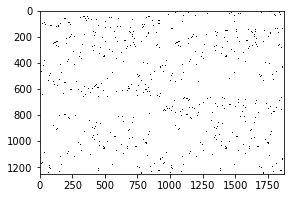

In [108]:
# copy Tα  on the edges

tensions = organo.upcast_face(organo.face_df['surface_tension']).to_numpy()

# compute \nabla A
grad_a_srce, grad_a_trgt = area_grad(organo)

taga_srce = (grad_a_srce * tensions[:, None]).to_numpy().ravel()
taga_trgt = (grad_a_trgt * tensions[:, None]).to_numpy().ravel()

data = np.concatenate((taga_srce, taga_trgt))

rows = organo.edge_df['face'].to_numpy().repeat(6)
surface_tension_mat = coo_matrix((data, (rows, cols)))
fig, ax = plt.subplots()

ax.imshow((surface_tension_mat != 0).todense(), cmap='Greys', interpolation=None)
fig.set_size_inches(12, 3)


In [104]:
surface_tension_mat.shape == (organo.Nf,  3 * organo.Nv)

True